## Exp4 Library effects on quantification accuracy analysis
**Spectronaut with inference correction**

In [18]:
#Importing packages 
import pandas as pd 
import numpy as np
import os 
import glob
import re
import seaborn as sns
import matplotlib.pyplot as plt
import umap
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import mstats
import dask.dataframe as dd
sns.set_style("ticks")

myColors = ["#7400b8","#6930c3","#5e60ce","#5390d9","#4ea8de","#48bfe3","#56cfe1","#64dfdf","#72efdd","#80ffdb"]

### Import all the data

In [19]:
def importData(filePath, dataFrameID=np.nan):

    #Data 
    df = pd.read_csv(filePath,sep = "\t", decimal=",") 
    #Extracting the required information from the file name
    df['Load'] =  df.iloc[:,0].str.extract(r'17w_(.*?)pg')[0].values
    df['Replicate'] =  df.iloc[:,0].str.extract(r'pg_(.)')[0].values

    df = df.replace(0, np.nan)

    #Adjust the incorrect loads

    df.Load.iloc[df.Load == '100']  = '500'
    df.Load.iloc[df.Load == '50']  = '250'
    df.Load.iloc[df.Load == '40']  = '200'
    df.Load.iloc[df.Load == '30']  = '150'
    df.Load.iloc[df.Load == '20']  = '100'
    df.Load.iloc[df.Load == '10']  = '50'

    #Add unique identifier for each peptide so it can be linked to specific file

    df['ID_string'] = df[['PEP.GroupingKey', 'Load', 'Replicate']].apply(lambda x: '_'.join(x), axis=1)

    df['ID'] = dataFrameID

    return df

In [20]:
full = importData("data/Exp4/Library/standartDIA_full.tsv", 'Full')
single = importData("data/Exp4/Library/standartDIA_single.tsv", 'Single')
Load = importData("data/Exp4/Library/standartDIA_load.tsv", 'Load')
lib100 = importData("data/Exp4/Library/standartDIA_50_100.tsv", 'Lib100')
lib150 = importData("data/Exp4/Library/standartDIA_50_150.tsv", 'Lib100')
lib200 = importData("data/Exp4/Library/standartDIA_50_200.tsv", 'Lib200')
lib250 = importData("data/Exp4/Library/standartDIA_50_250.tsv", 'Lib250')
lib500 = importData("data/Exp4/Library/standartDIA_50_500.tsv", 'Lib500')

/var/folders/fk/ycgfqq1520l3t9l7gs4wsjyr0000gp/T/ipykernel_2009/1768288896.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Load.iloc[df.Load == '100']  = '500'
/var/folders/fk/ycgfqq1520l3t9l7gs4wsjyr0000gp/T/ipykernel_2009/1768288896.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Load.iloc[df.Load == '50']  = '250'
/var/folders/fk/ycgfqq1520l3t9l7gs4wsjyr0000gp/T/ipykernel_2009/1768288896.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

#### Checking how many peptides are added by ID propagation

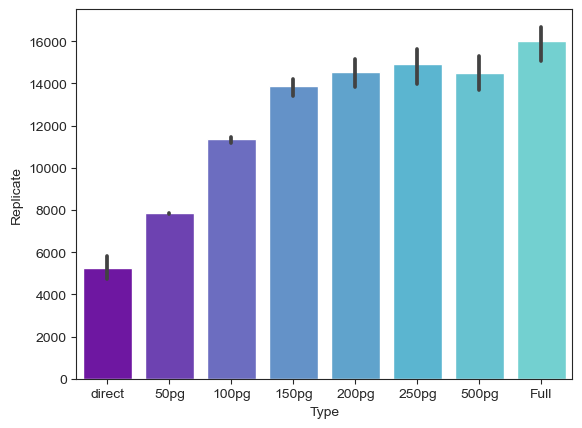

In [21]:


id_df = pd.DataFrame([np.concatenate((single.loc[single.Load == '50',:].value_counts('Replicate').values,
                Load.loc[Load.Load == '50',:].value_counts('Replicate').values,
                lib100.loc[lib100.Load == '50',:].value_counts('Replicate').values,
                lib150.loc[lib150.Load == '50',:].value_counts('Replicate').values,
                lib200.loc[lib200.Load == '50',:].value_counts('Replicate').values,
                lib250.loc[lib250.Load == '50',:].value_counts('Replicate').values,
                lib500.loc[lib500.Load == '50',:].value_counts('Replicate').values,
                full.loc[full.Load == '50',:].value_counts('Replicate').values
                )),
                
                np.repeat(['direct', '50pg', '100pg', '150pg', '200pg', '250pg', '500pg', 'Full'], repeats = 3)],

                index = ['Replicate', 'Type']).T

sns.barplot(data = id_df, x = 'Type', y = 'Replicate', palette = myColors)

id_df.to_csv('data/Exp4/output/library_ID.txt', sep = '\t')

### Mark the peptides found by direct DIA or from the same input in all the library searches 



In [22]:
full['direct'] = full.ID_string.isin(single.ID_string)
Load['direct'] = Load.ID_string.isin(single.ID_string)
lib100['direct'] = lib100.ID_string.isin(single.ID_string)
lib150['direct'] = lib150.ID_string.isin(single.ID_string)
lib200['direct'] = lib200.ID_string.isin(single.ID_string)
lib250['direct'] = lib250.ID_string.isin(single.ID_string)
lib500['direct'] = lib500.ID_string.isin(single.ID_string)

In [23]:
full['horizontal'] = full.ID_string.isin(Load.ID_string)
lib100['horizontal'] = lib100.ID_string.isin(Load.ID_string)
lib150['horizontal'] = lib150.ID_string.isin(Load.ID_string)
lib200['horizontal'] = lib200.ID_string.isin(Load.ID_string)
lib250['horizontal'] = lib250.ID_string.isin(Load.ID_string)
lib500['horizontal'] = lib500.ID_string.isin(Load.ID_string)

#### Lock the reference IDs to only be found by directDIA with not ID propagation

In [24]:
lock = True

if lock:
    full_lock = full.loc[(full.direct == True) | (full.Load == '50'), :]
    lib100_lock = lib100.loc[(lib100.direct == True) | (lib100.Load == '50'), :]
    lib150_lock = lib150.loc[(lib150.direct == True) | (lib150.Load == '50'), :]
    lib200_lock = lib200.loc[(lib200.direct == True) | (lib200.Load == '50'), :]
    lib250_lock = lib250.loc[(lib250.direct == True) | (lib250.Load == '50'), :]
    lib500_lock = lib500.loc[(lib500.direct == True) | (lib500.Load == '50'), :]

In [25]:
lib100.value_counts(['Load', 'horizontal'])

Load  horizontal
100   True          32778
50    True          22012
      False         12086
100   False          2585
dtype: int64

### Some quant tests

Load       abs_er_100            
                 mean         std
Type                             
direct      21.227635   70.182135
horizontal  27.096553   22.873185
library     51.567945  361.648585

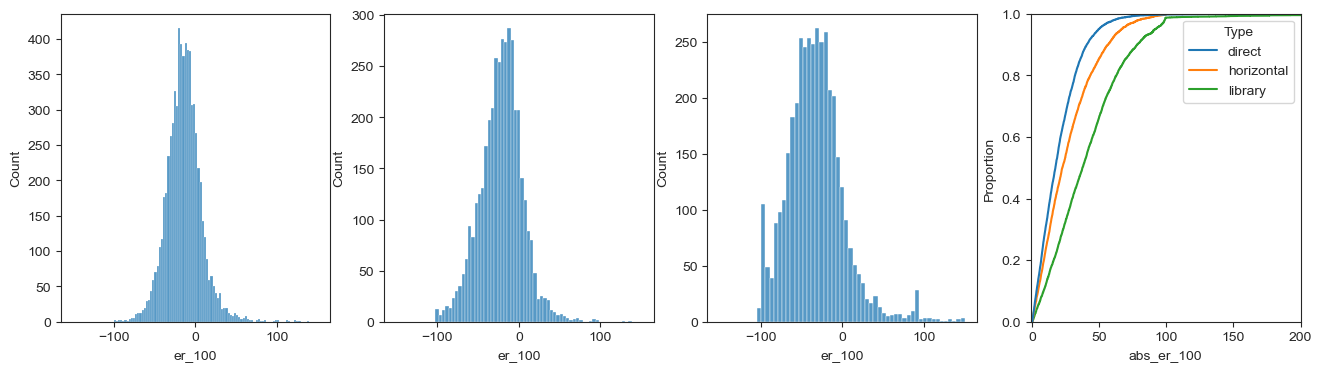

In [26]:
direct_q = lib100_lock.loc[lib100_lock.direct == True].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()
direct_q['Type'] = 'direct'
horizontal_q = lib100_lock.loc[((lib100_lock.direct == False) & (lib100_lock.horizontal == True)) | (lib100.Load == '100')].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()
horizontal_q['Type'] = 'horizontal'
library_q = lib100_lock.loc[((lib100_lock.direct == False) & (lib100_lock.horizontal == False)) | (lib100.Load == '100')].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()
library_q['Type'] = 'library'

q_df = pd.concat([direct_q, horizontal_q, library_q]).dropna()


q_df['er_100'] = (100/50 - (q_df['100']/q_df['50']))/(q_df['100']/q_df['50']) * 100
q_df['abs_er_100'] = np.abs(q_df['er_100'])

q_df = q_df.reset_index(drop=True)

fig, axes = plt.subplots(1,4, figsize = (16,4))
sns.histplot(data = q_df.loc[q_df.Type == 'direct'], x = 'er_100', ax =axes[0], binrange=(-150,150))
sns.histplot(data = q_df.loc[q_df.Type == 'horizontal'], x = 'er_100', ax =axes[1], binrange=(-150,150))
sns.histplot(data = q_df.loc[q_df.Type == 'library'], x = 'er_100', ax =axes[2], binrange=(-150,150))
sns.ecdfplot(data = q_df, x = 'abs_er_100', hue= 'Type', color = myColors).set(xlim = (-1,200))

q_df.groupby('Type').agg({'abs_er_100': ['mean', 'std']})


Load       abs_er_150            
                 mean         std
Type                             
direct      29.681839   93.794516
horizontal  51.854408  526.738559
library     58.443960  333.921259

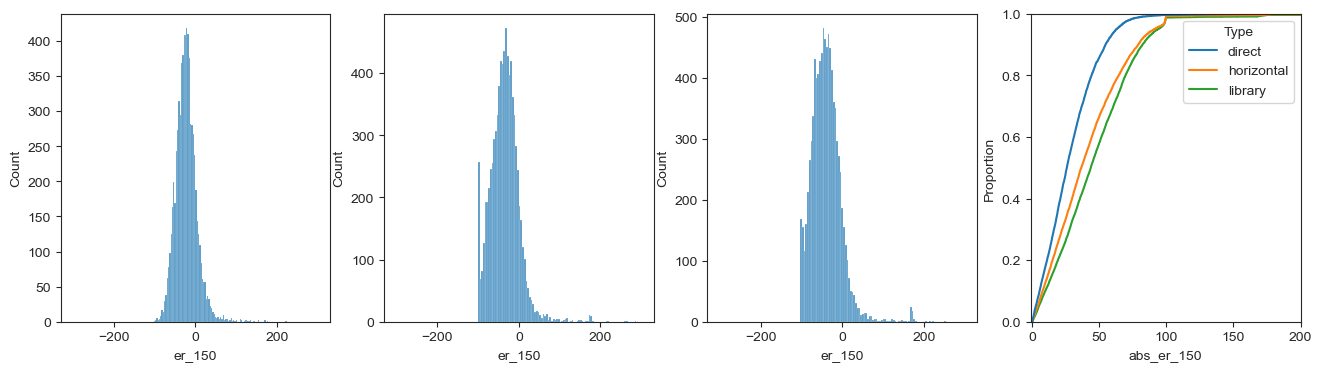

In [27]:
direct_q = lib150_lock.loc[lib150_lock.direct == True].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()
direct_q['Type'] = 'direct'
horizontal_q = lib150_lock.loc[((lib150_lock.direct == False) & (lib150_lock.horizontal == True)) | (lib100.Load == '100')].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()
horizontal_q['Type'] = 'horizontal'
library_q = lib150_lock.loc[((lib150_lock.direct == False) & (lib150_lock.horizontal == False)) | (lib100.Load == '100')].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()
library_q['Type'] = 'library'

q_df = pd.concat([direct_q, horizontal_q, library_q]).dropna()


q_df['er_150'] = (150/50 - (q_df['150']/q_df['50']))/(q_df['150']/q_df['50']) * 100
q_df['abs_er_150'] = np.abs(q_df['er_150'])

q_df = q_df.reset_index(drop=True)

fig, axes = plt.subplots(1,4, figsize = (16,4))
sns.histplot(data = q_df.loc[q_df.Type == 'direct'], x = 'er_150', ax =axes[0], binrange=(-300,300))
sns.histplot(data = q_df.loc[q_df.Type == 'horizontal'], x = 'er_150', ax =axes[1], binrange=(-300,300))
sns.histplot(data = q_df.loc[q_df.Type == 'library'], x = 'er_150', ax =axes[2], binrange=(-300,300))
sns.ecdfplot(data = q_df, x = 'abs_er_150', hue= 'Type', color = myColors).set(xlim = (-1,200))


q_df.groupby('Type').agg({'abs_er_150': ['mean', 'std']})

Load       abs_er_200             
                 mean          std
Type                              
direct      30.306415    25.063271
horizontal  71.282371  1769.071749
library     69.608264   813.085539

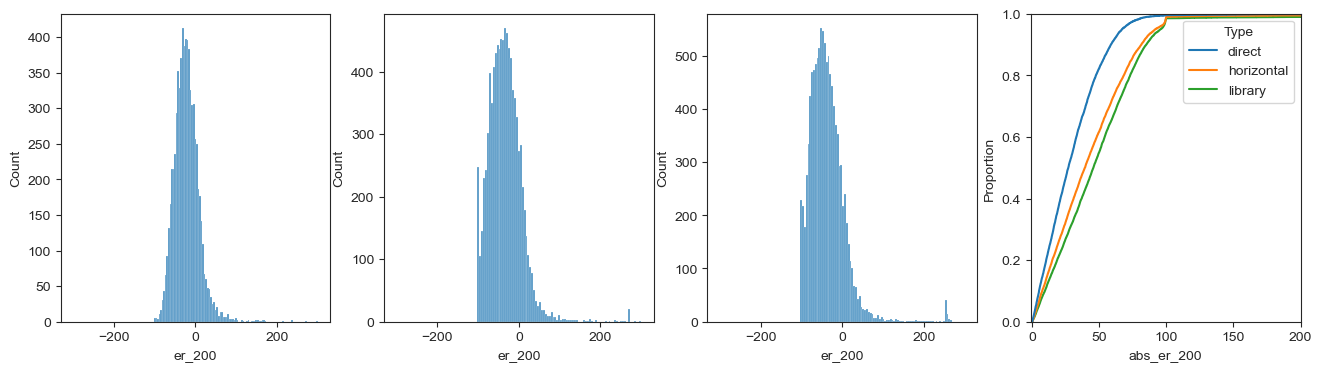

In [28]:
direct_q = lib200_lock.loc[lib200_lock.direct == True].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()
direct_q['Type'] = 'direct'
horizontal_q = lib200_lock.loc[((lib200_lock.direct == False) & (lib200_lock.horizontal == True)) | (lib100.Load == '100')].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()
horizontal_q['Type'] = 'horizontal'
library_q = lib200_lock.loc[((lib200_lock.direct == False) & (lib200_lock.horizontal == False)) | (lib100.Load == '100')].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()
library_q['Type'] = 'library'

q_df = pd.concat([direct_q, horizontal_q, library_q]).dropna()


q_df['er_200'] = (200/50 - (q_df['200']/q_df['50']))/(q_df['200']/q_df['50']) * 100
q_df['abs_er_200'] = np.abs(q_df['er_200'])

q_df = q_df.reset_index(drop=True)

fig, axes = plt.subplots(1,4, figsize = (16,4))
sns.histplot(data = q_df.loc[q_df.Type == 'direct'], x = 'er_200', ax =axes[0], binrange=(-300,300))
sns.histplot(data = q_df.loc[q_df.Type == 'horizontal'], x = 'er_200', ax =axes[1], binrange=(-300,300))
sns.histplot(data = q_df.loc[q_df.Type == 'library'], x = 'er_200', ax =axes[2], binrange=(-300,300))
sns.ecdfplot(data = q_df, x = 'abs_er_200', hue= 'Type', color = myColors).set(xlim = (-1,200))

q_df.groupby('Type').agg({'abs_er_200': ['mean', 'std']})

Load       abs_er_250            
                 mean         std
Type                             
direct      36.517962  153.296830
horizontal  54.740473  558.497359
library     67.091562  580.900545

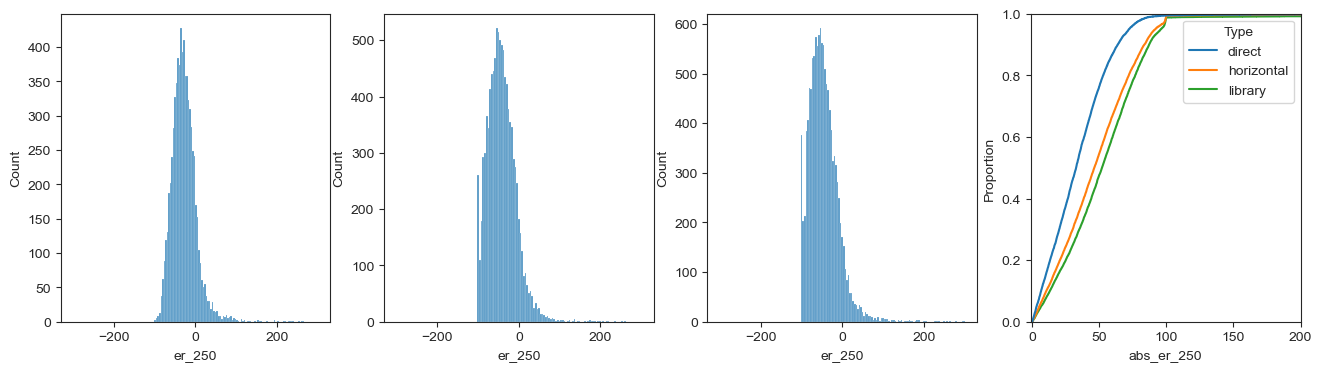

In [29]:
direct_q = lib250_lock.loc[lib250_lock.direct == True].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()
direct_q['Type'] = 'direct'
horizontal_q = lib250_lock.loc[((lib250_lock.direct == False) & (lib250_lock.horizontal == True)) | (lib100.Load == '100')].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()
horizontal_q['Type'] = 'horizontal'
library_q = lib250_lock.loc[((lib250_lock.direct == False) & (lib250_lock.horizontal == False)) | (lib100.Load == '100')].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()
library_q['Type'] = 'library'

q_df = pd.concat([direct_q, horizontal_q, library_q]).dropna()


q_df['er_250'] = (250/50 - (q_df['250']/q_df['50']))/(q_df['250']/q_df['50']) * 100
q_df['abs_er_250'] = np.abs(q_df['er_250'])

q_df = q_df.reset_index(drop=True)

fig, axes = plt.subplots(1,4, figsize = (16,4))
sns.histplot(data = q_df.loc[q_df.Type == 'direct'], x = 'er_250', ax =axes[0], binrange=(-300,300))
sns.histplot(data = q_df.loc[q_df.Type == 'horizontal'], x = 'er_250', ax =axes[1], binrange=(-300,300))
sns.histplot(data = q_df.loc[q_df.Type == 'library'], x = 'er_250', ax =axes[2], binrange=(-300,300))
sns.ecdfplot(data = q_df, x = 'abs_er_250', hue= 'Type', color = myColors).set(xlim = (-1,200))

q_df.groupby('Type').agg({'abs_er_250': ['mean', 'std']})

Load       abs_er_500            
                 mean         std
Type                             
direct      38.736808   30.573519
horizontal  58.852425  463.155236
library     73.052801  681.819443

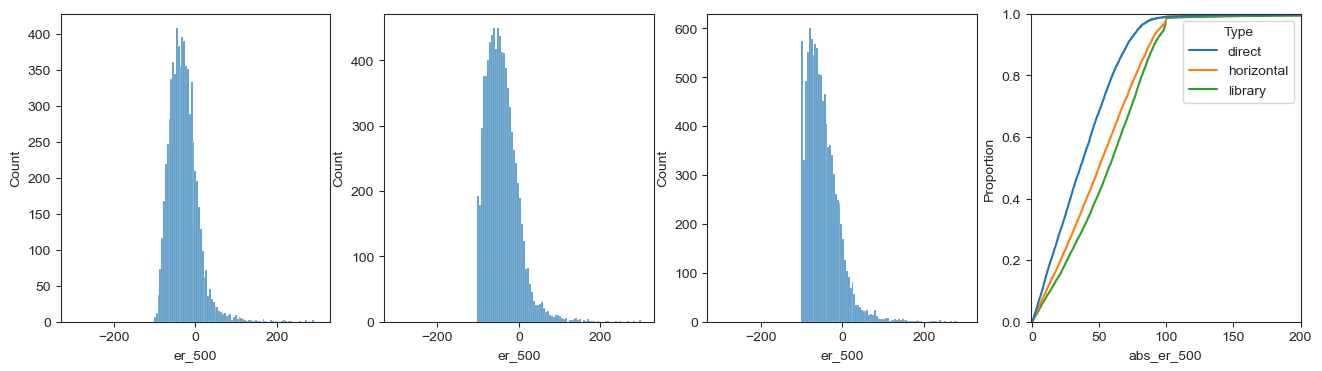

In [30]:
direct_q = lib500_lock.loc[lib500_lock.direct == True].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()
direct_q['Type'] = 'direct'
horizontal_q = lib500_lock.loc[((lib500_lock.direct == False) & (lib500_lock.horizontal == True)) | (lib100.Load == '100')].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()
horizontal_q['Type'] = 'horizontal'
library_q = lib500_lock.loc[((lib500_lock.direct == False) & (lib500_lock.horizontal == False)) | (lib100.Load == '100')].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()
library_q['Type'] = 'library'

q_df = pd.concat([direct_q, horizontal_q, library_q]).dropna()


q_df['er_500'] = (500/50 - (q_df['500']/q_df['50']))/(q_df['500']/q_df['50']) * 100
q_df['abs_er_500'] = np.abs(q_df['er_500'])

q_df = q_df.reset_index(drop=True)

fig, axes = plt.subplots(1,4, figsize = (16,4))
sns.histplot(data = q_df.loc[q_df.Type == 'direct'], x = 'er_500', ax =axes[0], binrange=(-300,300))
sns.histplot(data = q_df.loc[q_df.Type == 'horizontal'], x = 'er_500', ax =axes[1], binrange=(-300,300))
sns.histplot(data = q_df.loc[q_df.Type == 'library'], x = 'er_500', ax =axes[2], binrange=(-300,300))
sns.ecdfplot(data = q_df, x = 'abs_er_500', hue= 'Type', color = myColors).set(xlim = (-1,200))


q_df.groupby('Type').agg({'abs_er_500': ['mean', 'std']})

#### Comparing MS1 vs MS2 direct quantification 

In [31]:
q_100_ms1 = lib100_lock.loc[lib100_lock.direct == True].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()
q_150_ms1 = lib150_lock.loc[lib150_lock.direct == True].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()
q_200_ms1 = lib200_lock.loc[lib200_lock.direct == True].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()
q_250_ms1 = lib250_lock.loc[lib250_lock.direct == True].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()
q_500_ms1 = lib500_lock.loc[lib500_lock.direct == True].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()


q_100_ms2 = lib100_lock.loc[lib100_lock.direct == True].pivot_table(values="PEP.MS2Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()
q_150_ms2 = lib150_lock.loc[lib150_lock.direct == True].pivot_table(values="PEP.MS2Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()
q_200_ms2 = lib200_lock.loc[lib200_lock.direct == True].pivot_table(values="PEP.MS2Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()
q_250_ms2 = lib250_lock.loc[lib250_lock.direct == True].pivot_table(values="PEP.MS2Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()
q_500_ms2 = lib500_lock.loc[lib500_lock.direct == True].pivot_table(values="PEP.MS2Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()

#Adding labels
q_100_ms1['Load'] = '100'
q_150_ms1['Load'] = '150'
q_200_ms1['Load'] = '200'
q_250_ms1['Load'] = '250'
q_500_ms1['Load'] = '500'

q_100_ms2['Load'] = '100'
q_150_ms2['Load'] = '150'
q_200_ms2['Load'] = '200'
q_250_ms2['Load'] = '250'
q_500_ms2['Load'] = '500'


q_100_ms1['Type'] = 'MS1'
q_150_ms1['Type'] = 'MS1'
q_200_ms1['Type'] = 'MS1'
q_250_ms1['Type'] = 'MS1'
q_500_ms1['Type'] = 'MS1'

q_100_ms2['Type'] = 'MS2'
q_150_ms2['Type'] = 'MS2'
q_200_ms2['Type'] = 'MS2'
q_250_ms2['Type'] = 'MS2'
q_500_ms2['Type'] = 'MS2'

#Calculating error 

q_100_ms1['er'] = (100/50 - (q_100_ms1['100']/q_100_ms1['50']))/(q_100_ms1['100']/q_100_ms1['50']) * 100
q_150_ms1['er'] = (150/50 - (q_150_ms1['150']/q_150_ms1['50']))/(q_150_ms1['150']/q_150_ms1['50']) * 100
q_200_ms1['er'] = (200/50 - (q_200_ms1['200']/q_200_ms1['50']))/(q_200_ms1['200']/q_200_ms1['50']) * 100
q_250_ms1['er'] = (250/50 - (q_250_ms1['250']/q_250_ms1['50']))/(q_250_ms1['250']/q_250_ms1['50']) * 100
q_500_ms1['er'] = (500/50 - (q_500_ms1['500']/q_500_ms1['50']))/(q_500_ms1['500']/q_500_ms1['50']) * 100

q_100_ms2['er'] = (100/50 - (q_100_ms2['100']/q_100_ms2['50']))/(q_100_ms2['100']/q_100_ms2['50']) * 100
q_150_ms2['er'] = (150/50 - (q_150_ms2['150']/q_150_ms2['50']))/(q_150_ms2['150']/q_150_ms2['50']) * 100
q_200_ms2['er'] = (200/50 - (q_200_ms2['200']/q_200_ms2['50']))/(q_200_ms2['200']/q_200_ms2['50']) * 100
q_250_ms2['er'] = (250/50 - (q_250_ms2['250']/q_250_ms2['50']))/(q_250_ms2['250']/q_250_ms2['50']) * 100
q_500_ms2['er'] = (500/50 - (q_500_ms2['500']/q_500_ms2['50']))/(q_500_ms2['500']/q_500_ms2['50']) * 100


q_100_ms1['er_abs'] = np.abs(q_100_ms1['er'])
q_150_ms1['er_abs'] = np.abs(q_150_ms1['er'])
q_200_ms1['er_abs'] = np.abs(q_200_ms1['er'])
q_250_ms1['er_abs'] = np.abs(q_250_ms1['er'])
q_500_ms1['er_abs'] = np.abs(q_500_ms1['er'])

q_100_ms2['er_abs'] = np.abs(q_100_ms2['er'])
q_150_ms2['er_abs'] = np.abs(q_150_ms2['er'])
q_200_ms2['er_abs'] = np.abs(q_200_ms2['er'])
q_250_ms2['er_abs'] = np.abs(q_250_ms2['er'])
q_500_ms2['er_abs'] = np.abs(q_500_ms2['er'])

#Select only the needed columns 

q_100_ms1 = q_100_ms1[['er', 'er_abs', 'Type', 'Load']]
q_150_ms1 = q_150_ms1[['er', 'er_abs', 'Type', 'Load']]
q_200_ms1 = q_200_ms1[['er', 'er_abs', 'Type', 'Load']]
q_250_ms1 = q_250_ms1[['er', 'er_abs', 'Type', 'Load']]
q_500_ms1 = q_500_ms1[['er', 'er_abs', 'Type', 'Load']]

q_100_ms2 = q_100_ms2[['er', 'er_abs', 'Type', 'Load']]
q_150_ms2 = q_150_ms2[['er', 'er_abs', 'Type', 'Load']]
q_200_ms2 = q_200_ms2[['er', 'er_abs', 'Type', 'Load']]
q_250_ms2 = q_250_ms2[['er', 'er_abs', 'Type', 'Load']]
q_500_ms2 = q_500_ms2[['er', 'er_abs', 'Type', 'Load']]

q_df = pd.concat([q_100_ms1, q_150_ms1, q_200_ms1, q_250_ms1, q_500_ms1, q_100_ms2, q_150_ms2, q_200_ms2, q_250_ms2, q_500_ms2]).dropna().reset_index(drop=True)
q_df

Load,er,er_abs,Type,Load
0,-4.574604,4.574604,MS1,100
1,2.489101,2.489101,MS1,100
2,-12.793759,12.793759,MS1,100
3,-19.827336,19.827336,MS1,100
4,-0.579741,0.579741,MS1,100
...,...,...,...,...
70265,-11.382665,11.382665,MS2,500
70266,-13.850724,13.850724,MS2,500
70267,-24.374154,24.374154,MS2,500
70268,-32.001956,32.001956,MS2,500


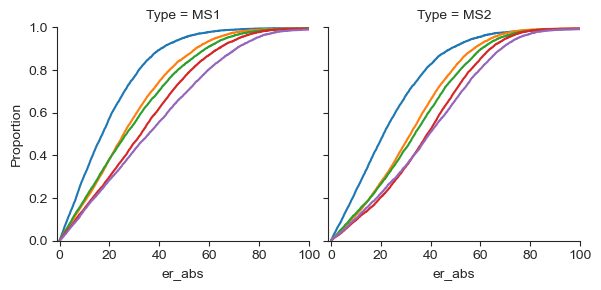

In [32]:
g = sns.FacetGrid(q_df, col="Type", hue = 'Load', legend_out=True)
g.map(sns.ecdfplot, "er_abs", ).set(xlim = (-1,100))

In [33]:
q_df.to_csv("data/Exp4/output/direct_error.txt", sep = "\t", index = False)
print(q_df.groupby(['Type', 'Load']).mean())
print(q_df.groupby(['Type', 'Load']).std())

Load              er     er_abs
Type Load                      
MS1  100  -12.769241  21.227635
     150  -21.180712  29.681839
     200  -20.894089  30.306415
     250  -25.148345  36.517962
     500  -27.808881  38.736808
MS2  100  -13.504615  24.945788
     150  -26.298159  33.239621
     200  -27.245669  34.943212
     250  -32.745425  38.801553
     500  -31.370090  40.731632
Load               er      er_abs
Type Load                        
MS1  100    72.202029   70.182135
     150    96.072168   93.794516
     200    33.318937   25.063271
     250   155.567151  153.296830
     500    40.768253   30.573519
MS2  100    29.986467   21.429100
     150    32.041505   24.765304
     200    32.631923   24.208946
     250    30.354722   22.091872
     500    43.224498   34.543847


### Full quant - MS1

In [34]:
quant_ms1 = full.pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()


<AxesSubplot:xlabel='er_100', ylabel='Count'>

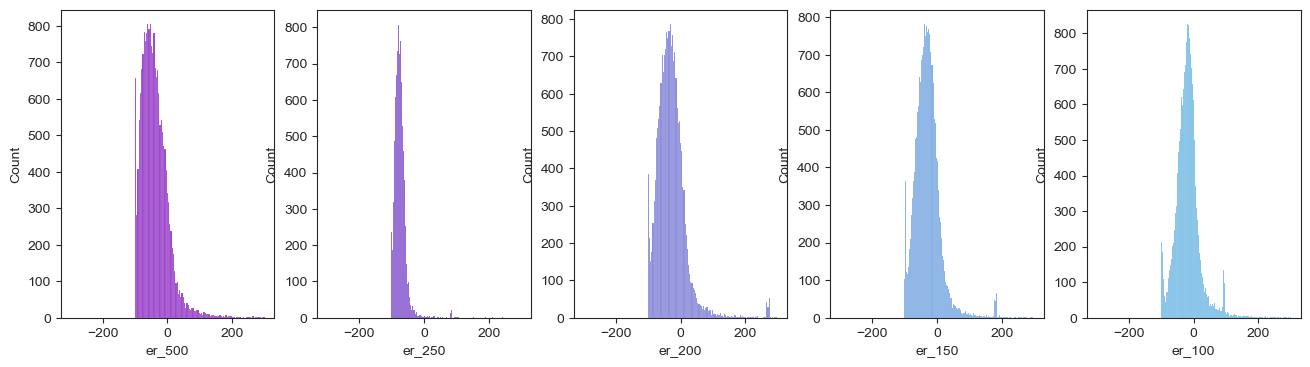

In [35]:
#Everything relative to 50pg
quant_ms1['er_500'] = (500/50 - (quant_ms1['500']/quant_ms1['50']))/(quant_ms1['500']/quant_ms1['50']) * 100
quant_ms1['er_250'] = (100/50 - (quant_ms1['250']/quant_ms1['50']))/(quant_ms1['250']/quant_ms1['50']) * 100
quant_ms1['er_200'] = (200/50 - (quant_ms1['200']/quant_ms1['50']))/(quant_ms1['200']/quant_ms1['50']) * 100
quant_ms1['er_150'] = (150/50 - (quant_ms1['150']/quant_ms1['50']))/(quant_ms1['150']/quant_ms1['50']) * 100
quant_ms1['er_100'] = (100/50 - (quant_ms1['100']/quant_ms1['50']))/(quant_ms1['100']/quant_ms1['50']) * 100



fig, axes = plt.subplots(1,5, figsize = (16,4))
sns.histplot(data = quant_ms1, x = 'er_500', color = myColors[0], ax =axes[0], binrange=(-300,300))
sns.histplot(data = quant_ms1, x = 'er_250', color = myColors[1], ax =axes[1], binrange=(-300,300))
sns.histplot(data = quant_ms1, x = 'er_200', color = myColors[2], ax =axes[2], binrange=(-300,300))
sns.histplot(data = quant_ms1, x = 'er_150', color = myColors[3], ax =axes[3], binrange=(-300,300))
sns.histplot(data = quant_ms1, x = 'er_100', color = myColors[4], ax =axes[4], binrange=(-300,300))

#### Direct only quant - MS1

In [36]:
direct_ms1 = full.loc[full.direct == True].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()
direct_ms2 = full.loc[full.direct == True].pivot_table(values="PEP.MS2Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()

<AxesSubplot:xlabel='er_100', ylabel='Count'>

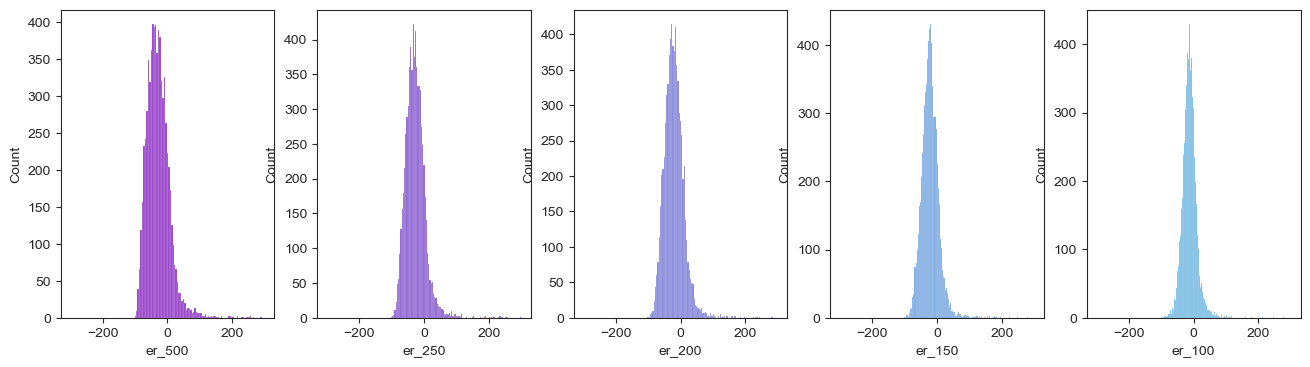

In [37]:
#Everything relative to 50pg
direct_ms1['er_500'] = (500/50 - (direct_ms1['500']/direct_ms1['50']))/(direct_ms1['500']/direct_ms1['50']) * 100
direct_ms1['er_250'] = (250/50 - (direct_ms1['250']/direct_ms1['50']))/(direct_ms1['250']/direct_ms1['50']) * 100
direct_ms1['er_200'] = (200/50 - (direct_ms1['200']/direct_ms1['50']))/(direct_ms1['200']/direct_ms1['50']) * 100
direct_ms1['er_150'] = (150/50 - (direct_ms1['150']/direct_ms1['50']))/(direct_ms1['150']/direct_ms1['50']) * 100
direct_ms1['er_100'] = (100/50 - (direct_ms1['100']/direct_ms1['50']))/(direct_ms1['100']/direct_ms1['50']) * 100



fig, axes = plt.subplots(1,5, figsize = (16,4))
sns.histplot(data = direct_ms1, x = 'er_500', color = myColors[0], ax =axes[0], binrange=(-300,300))
sns.histplot(data = direct_ms1, x = 'er_250', color = myColors[1], ax =axes[1], binrange=(-300,300))
sns.histplot(data = direct_ms1, x = 'er_200', color = myColors[2], ax =axes[2], binrange=(-300,300))
sns.histplot(data = direct_ms1, x = 'er_150', color = myColors[3], ax =axes[3], binrange=(-300,300))
sns.histplot(data = direct_ms1, x = 'er_100', color = myColors[4], ax =axes[4], binrange=(-300,300))

<AxesSubplot:xlabel='er_100', ylabel='Count'>

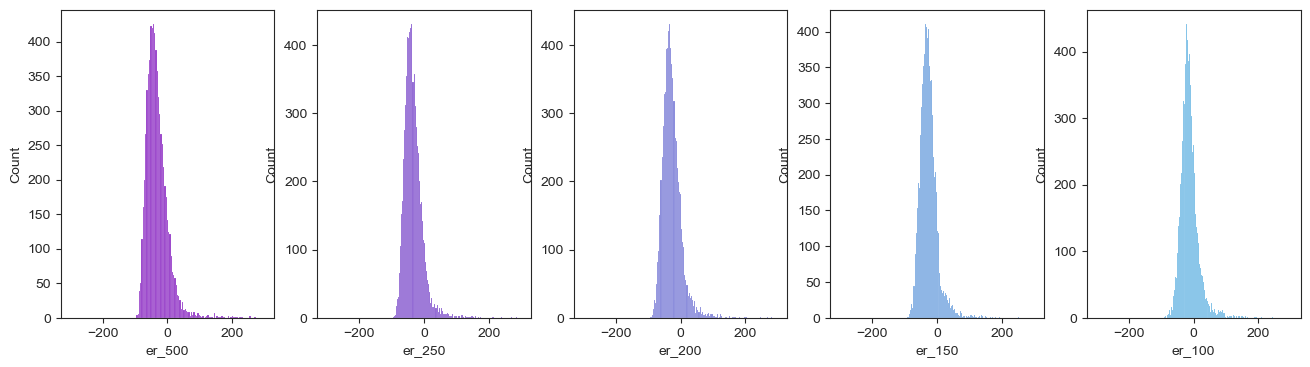

In [38]:
#Everything relative to 50pg
direct_ms2['er_500'] = (500/50 - (direct_ms2['500']/direct_ms2['50']))/(direct_ms2['500']/direct_ms2['50']) * 100
direct_ms2['er_250'] = (250/50 - (direct_ms2['250']/direct_ms2['50']))/(direct_ms2['250']/direct_ms2['50']) * 100
direct_ms2['er_200'] = (200/50 - (direct_ms2['200']/direct_ms2['50']))/(direct_ms2['200']/direct_ms2['50']) * 100
direct_ms2['er_150'] = (150/50 - (direct_ms2['150']/direct_ms2['50']))/(direct_ms2['150']/direct_ms2['50']) * 100
direct_ms2['er_100'] = (100/50 - (direct_ms2['100']/direct_ms2['50']))/(direct_ms2['100']/direct_ms2['50']) * 100



fig, axes = plt.subplots(1,5, figsize = (16,4))
sns.histplot(data = direct_ms2, x = 'er_500', color = myColors[0], ax =axes[0], binrange=(-300,300))
sns.histplot(data = direct_ms2, x = 'er_250', color = myColors[1], ax =axes[1], binrange=(-300,300))
sns.histplot(data = direct_ms2, x = 'er_200', color = myColors[2], ax =axes[2], binrange=(-300,300))
sns.histplot(data = direct_ms2, x = 'er_150', color = myColors[3], ax =axes[3], binrange=(-300,300))
sns.histplot(data = direct_ms2, x = 'er_100', color = myColors[4], ax =axes[4], binrange=(-300,300))

In [39]:
direct_ms1['Type'] = 'MS1'
direct_ms2['Type'] = 'MS2'

pd.concat([direct_ms1, direct_ms2]).dropna().to_csv("data/Exp4/output/direct_error_full.txt", sep = "\t", index = False)

In [40]:
### Add label to show at which load the IDs is added 
top_list = full.loc[full.Load == '500','PEP.GroupingKey'].unique()


full_top = full.loc[full['PEP.GroupingKey'].isin(top_list), :]
#full_top = full_top.loc[(full_top.direct == True) | (full_top.Load == '50'), :]

quant_ms1 = full_top.pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index();quant_ms1['Level'] = 'MS1'
quant_ms2 = full_top.pivot_table(values="PEP.MS2Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index();quant_ms2['Level'] = 'MS2'

#Error calculation. Everything relative to 50pg
quant_ms1['er_500'] = (500/50 - (quant_ms1['500']/quant_ms1['50']))/(quant_ms1['500']/quant_ms1['50']) * 100
quant_ms1['er_250'] = (250/50 - (quant_ms1['250']/quant_ms1['50']))/(quant_ms1['250']/quant_ms1['50']) * 100
quant_ms1['er_200'] = (200/50 - (quant_ms1['200']/quant_ms1['50']))/(quant_ms1['200']/quant_ms1['50']) * 100
quant_ms1['er_150'] = (150/50 - (quant_ms1['150']/quant_ms1['50']))/(quant_ms1['150']/quant_ms1['50']) * 100
quant_ms1['er_100'] = (100/50 - (quant_ms1['100']/quant_ms1['50']))/(quant_ms1['100']/quant_ms1['50']) * 100


quant_ms2['er_500'] = (500/50 - (quant_ms2['500']/quant_ms2['50']))/(quant_ms2['500']/quant_ms2['50']) * 100
quant_ms2['er_250'] = (250/50 - (quant_ms2['100']/quant_ms2['50']))/(quant_ms2['250']/quant_ms2['50']) * 100
quant_ms2['er_200'] = (200/50 - (quant_ms2['200']/quant_ms2['50']))/(quant_ms2['200']/quant_ms2['50']) * 100
quant_ms2['er_150'] = (150/50 - (quant_ms2['150']/quant_ms2['50']))/(quant_ms2['150']/quant_ms2['50']) * 100
quant_ms2['er_100'] = (100/50 - (quant_ms2['100']/quant_ms2['50']))/(quant_ms2['100']/quant_ms2['50']) * 100


#Combine MS1 and MS2
quant = pd.concat([quant_ms1, quant_ms2]).dropna().reset_index(drop=True) # Keep only completelly identified peptides

quant['direct'] = quant['PEP.GroupingKey'].isin(single.loc[single.Load == '50', 'PEP.GroupingKey'])
quant['50pg_Lib'] = quant['PEP.GroupingKey'].isin(Load.loc[Load.Load == '50', 'PEP.GroupingKey'])
quant['100pg_Lib'] = quant['PEP.GroupingKey'].isin(Load.loc[Load.Load == '100', 'PEP.GroupingKey'])
quant['150pg_Lib'] = quant['PEP.GroupingKey'].isin(Load.loc[Load.Load == '150', 'PEP.GroupingKey'])
quant['200pg_Lib'] = quant['PEP.GroupingKey'].isin(Load.loc[Load.Load == '200', 'PEP.GroupingKey'])
quant['250pg_Lib'] = quant['PEP.GroupingKey'].isin(Load.loc[Load.Load == '250', 'PEP.GroupingKey'])
quant['500pg_Lib'] = quant['PEP.GroupingKey'].isin(Load.loc[Load.Load == '500', 'PEP.GroupingKey'])
1

quant.loc[(quant.direct == False)]

Load,PEP.GroupingKey,100,150,200,250,50,500,Level,er_500,er_250,er_200,er_150,er_100,direct,50pg_Lib,100pg_Lib,150pg_Lib,200pg_Lib,250pg_Lib,500pg_Lib
2,_AAAAASAAGPGGLVAGK_,17.997612,16.461624,46.736942,51.268478,6.394598,102.762169,MS1,-37.772835,-37.636159,-45.271572,16.536469,-28.939478,False,False,False,False,False,False,True
3,_AAAASVPNADGLK_,21.492040,37.956398,47.102150,84.583265,16.625342,157.259898,MS1,5.718890,-1.722037,41.185419,31.403474,54.711625,False,False,False,False,False,False,True
4,_AAAAVEPDVVVK_,69.827782,77.660517,118.101753,165.735331,28.290107,340.547384,MS1,-16.927545,-14.652757,-4.183955,9.283745,-18.971771,False,False,True,True,True,True,True
5,_AAAAVVAAAAR_,86.244665,126.113365,152.339579,183.028656,37.896955,390.276815,MS1,-2.897241,3.527383,-0.493475,-9.850263,-12.117565,False,False,False,False,False,False,True
10,_AAAGAAATHLEVAR_,110.293732,248.059921,303.821147,465.960398,33.067703,1186.636190,MS1,-72.133242,-64.516616,-56.464251,-60.008409,-40.037022,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38288,_[Acetyl (Protein N-term)]STNENANTPAAR_,9.546948,16.485398,16.480247,21.495054,1.835586,37.676870,MS2,-51.280815,-1.716751,-55.447599,-66.596141,-61.546113,False,False,True,True,True,True,True
38291,_[Acetyl (Protein N-term)]TAVHAGNINFK_,2.785348,10.364174,11.559865,14.362428,2.100740,35.435054,MS2,-40.715760,53.739893,-27.309181,-39.192254,50.842213,False,False,True,True,True,True,True
38296,_[Acetyl (Protein N-term)]THSLVC[Carbamidometh...,1.928508,5.740187,8.095218,10.216648,1.561570,22.176100,MS2,-29.583184,57.546705,-22.839864,-18.387491,61.945988,False,False,False,False,False,False,True
38297,_[Acetyl (Protein N-term)]TTNAGPLHPYWPQHLR_,4.330978,15.365171,28.126877,30.330966,3.252989,116.709991,MS2,-72.127591,39.345812,-53.738360,-36.486450,50.219574,False,False,False,True,True,True,True


In [41]:
### Add label to show at which load the IDs is added 
top_list = full.loc[full.Load == '500','PEP.GroupingKey'].unique()

In [42]:
temp = (quant[['direct','50pg_Lib', '100pg_Lib', '150pg_Lib', '200pg_Lib', '250pg_Lib', '500pg_Lib']] *1).apply(lambda x: ''.join(x.astype(str)), axis = 1)
#temp = (quant[['direct','50pg_Lib', '100pg_Lib', '200pg_Lib']] *1).apply(lambda x: ''.join(x.astype(str)), axis = 1)

In [43]:
pd.Series(temp).value_counts()



1111111    12092
0011111     5496
0001111     3314
0000000     2106
0000111     1692
           ...  
1000101        2
1000100        2
0110101        2
1010100        2
1010101        2
Length: 120, dtype: int64

In [44]:
test = temp[0]

def getLimit(x):

    if x[0] == '1':
        return 'direct'
    elif x[1] == '1':
        return '50pg'
    elif x[2] == '1':
        return '100pg'
    elif x[3] == '1':    
        return '150pg'
    elif x[4] == '1':
        return '200pg'
    elif x[5] == '1':
        return '250pg'
    elif x[6] == '1':
        return '500pg'
    else:
        return np.nan


limit_list = []

for i in temp:
    limit_list.append(getLimit(i))

quant['limit'] = limit_list

[(-1.0, 200.0)]

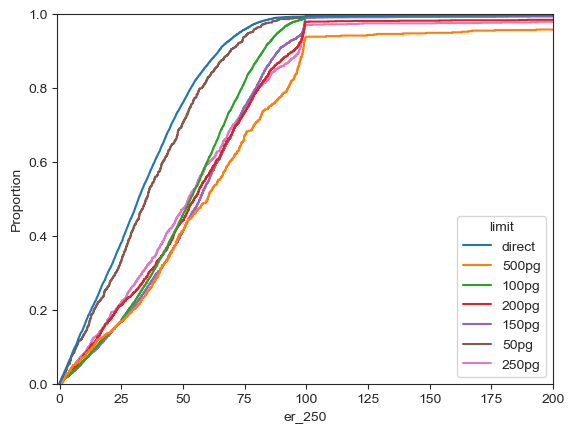

In [45]:
sns.ecdfplot(data = quant.loc[quant.Level == 'MS1'], x = np.abs(quant.er_250), hue= 'limit', color = myColors).set(xlim = (-1,200))

In [46]:
quant.groupby(['Level','limit']).agg({'er_100': ['mean', 'std']})

Load              er_100            
                    mean         std
Level limit                         
MS1   100pg   -28.916506   31.780028
      150pg     6.087263  436.355064
      200pg    13.100593  415.881500
      250pg    58.225665  671.996995
      500pg   101.908970  855.720097
      50pg    -16.097270   26.847287
      direct  -13.349125   43.491519
MS2   100pg   -15.603789   40.480924
      150pg     4.504765   69.285819
      200pg    14.816147   81.687076
      250pg    25.168198  105.270492
      500pg    38.465228  137.804988
      50pg    -10.260028   39.517935
      direct  -15.285035   26.271075

In [47]:
quant.groupby(['Level','limit'])['er_100'].apply(lambda x: sum(np.abs(x) < 25)/len(x))
quant.groupby(['Level','limit'])['er_200'].apply(lambda x: sum(np.abs(x) < 25)/len(x))

Level  limit 
MS1    100pg     0.224299
       150pg     0.212509
       200pg     0.247031
       250pg     0.262281
       500pg     0.208333
       50pg      0.411844
       direct    0.473750
MS2    100pg     0.226435
       150pg     0.290334
       200pg     0.330760
       250pg     0.327227
       500pg     0.279762
       50pg      0.300135
       direct    0.325228
Name: er_200, dtype: float64

In [48]:
quant.to_csv('data/Exp4/output/library_quant.txt', sep = '\t', index = False)

#### Library only -MS1

In [49]:
quant_ms1 = full.loc[(full.direct == False) & (full.horizontal == True)].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()

<AxesSubplot:xlabel='er_100', ylabel='Count'>

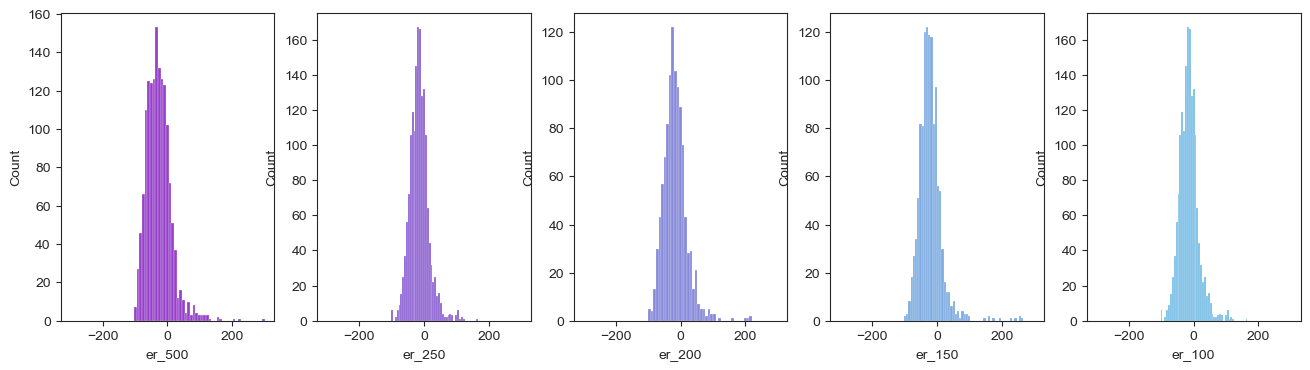

In [50]:
#Everything relative to 50pg
quant_ms1['er_500'] = (500/50 - (quant_ms1['500']/quant_ms1['50']))/(quant_ms1['500']/quant_ms1['50']) * 100
quant_ms1['er_250'] = (100/50 - (quant_ms1['100']/quant_ms1['50']))/(quant_ms1['100']/quant_ms1['50']) * 100
quant_ms1['er_200'] = (200/50 - (quant_ms1['200']/quant_ms1['50']))/(quant_ms1['200']/quant_ms1['50']) * 100
quant_ms1['er_150'] = (150/50 - (quant_ms1['150']/quant_ms1['50']))/(quant_ms1['150']/quant_ms1['50']) * 100
quant_ms1['er_100'] = (100/50 - (quant_ms1['100']/quant_ms1['50']))/(quant_ms1['100']/quant_ms1['50']) * 100



fig, axes = plt.subplots(1,5, figsize = (16,4))
sns.histplot(data = quant_ms1, x = 'er_500', color = myColors[0], ax =axes[0], binrange=(-300,300))
sns.histplot(data = quant_ms1, x = 'er_250', color = myColors[1], ax =axes[1], binrange=(-300,300))
sns.histplot(data = quant_ms1, x = 'er_200', color = myColors[2], ax =axes[2], binrange=(-300,300))
sns.histplot(data = quant_ms1, x = 'er_150', color = myColors[3], ax =axes[3], binrange=(-300,300))
sns.histplot(data = quant_ms1, x = 'er_100', color = myColors[4], ax =axes[4], binrange=(-300,300))

# ---------------

### Full quant - MS2

In [51]:
quant_ms1 = full.pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()
quant_ms2 = full.pivot_table(values="PEP.MS2Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()

<AxesSubplot:xlabel='er_100', ylabel='Count'>

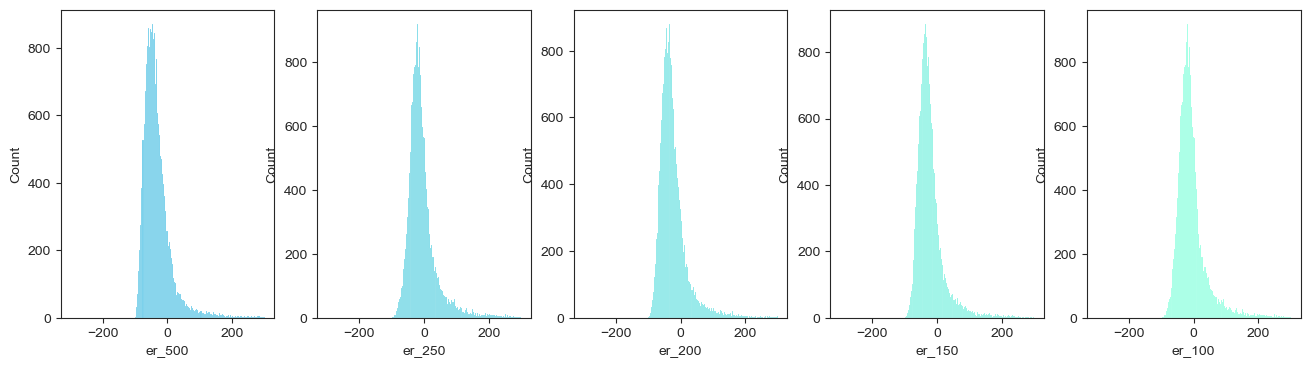

In [52]:
#Everything relative to 50pg
quant_ms2['er_500'] = (500/50 - (quant_ms2['500']/quant_ms2['50']))/(quant_ms2['500']/quant_ms2['50']) * 100
quant_ms2['er_250'] = (100/50 - (quant_ms2['100']/quant_ms2['50']))/(quant_ms2['100']/quant_ms2['50']) * 100
quant_ms2['er_200'] = (200/50 - (quant_ms2['200']/quant_ms2['50']))/(quant_ms2['200']/quant_ms2['50']) * 100
quant_ms2['er_150'] = (150/50 - (quant_ms2['150']/quant_ms2['50']))/(quant_ms2['150']/quant_ms2['50']) * 100
quant_ms2['er_100'] = (100/50 - (quant_ms2['100']/quant_ms2['50']))/(quant_ms2['100']/quant_ms2['50']) * 100



fig, axes = plt.subplots(1,5, figsize = (16,4))
sns.histplot(data = quant_ms2, x = 'er_500', color = myColors[5], ax =axes[0], binrange=(-300,300))
sns.histplot(data = quant_ms2, x = 'er_250', color = myColors[6], ax =axes[1], binrange=(-300,300))
sns.histplot(data = quant_ms2, x = 'er_200', color = myColors[7], ax =axes[2], binrange=(-300,300))
sns.histplot(data = quant_ms2, x = 'er_150', color = myColors[8], ax =axes[3], binrange=(-300,300))
sns.histplot(data = quant_ms2, x = 'er_100', color = myColors[9], ax =axes[4], binrange=(-300,300))

[(-1.0, 200.0)]

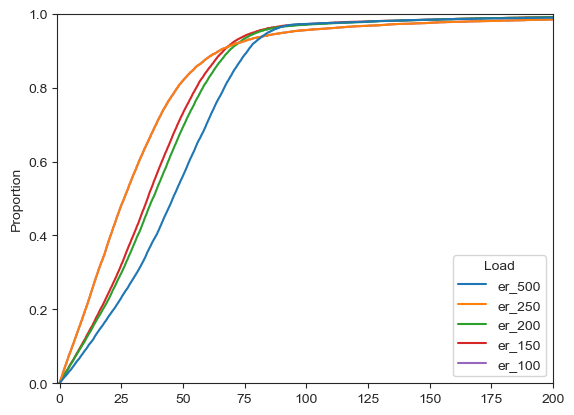

In [53]:
sns.ecdfplot(np.abs(quant_ms2[['er_500','er_250', 'er_200', 'er_150', 'er_100']]), color = myColors).set(xlim = (-1,200))

#### Direct only quant - MS2

In [54]:
quant_ms1 = full.loc[full.direct == True].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()
quant_ms2 = full.loc[full.direct == True].pivot_table(values="PEP.MS2Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()

<AxesSubplot:xlabel='er_100', ylabel='Count'>

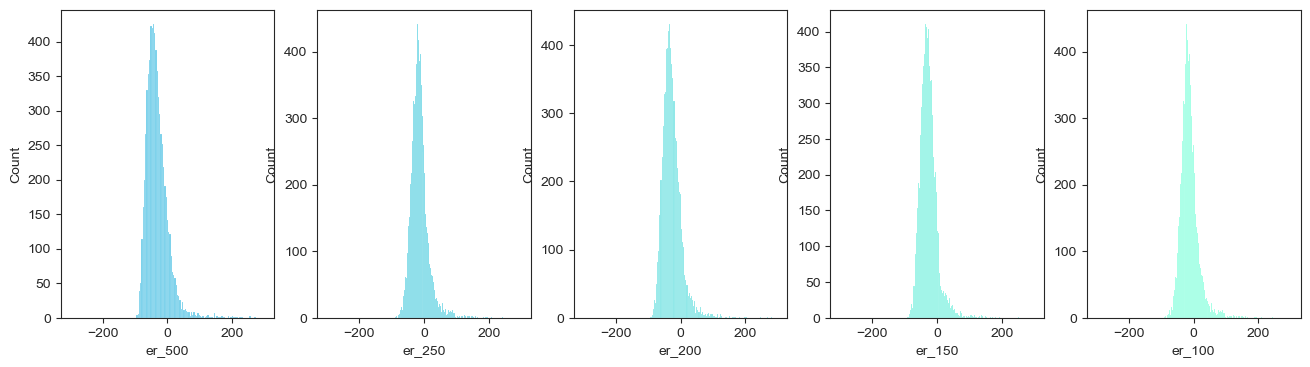

In [55]:
#Everything relative to 50pg
quant_ms2['er_500'] = (500/50 - (quant_ms2['500']/quant_ms2['50']))/(quant_ms2['500']/quant_ms2['50']) * 100
quant_ms2['er_250'] = (100/50 - (quant_ms2['100']/quant_ms2['50']))/(quant_ms2['100']/quant_ms2['50']) * 100
quant_ms2['er_200'] = (200/50 - (quant_ms2['200']/quant_ms2['50']))/(quant_ms2['200']/quant_ms2['50']) * 100
quant_ms2['er_150'] = (150/50 - (quant_ms2['150']/quant_ms2['50']))/(quant_ms2['150']/quant_ms2['50']) * 100
quant_ms2['er_100'] = (100/50 - (quant_ms2['100']/quant_ms2['50']))/(quant_ms2['100']/quant_ms2['50']) * 100



fig, axes = plt.subplots(1,5, figsize = (16,4))
sns.histplot(data = quant_ms2, x = 'er_500', color = myColors[5], ax =axes[0], binrange=(-300,300))
sns.histplot(data = quant_ms2, x = 'er_250', color = myColors[6], ax =axes[1], binrange=(-300,300))
sns.histplot(data = quant_ms2, x = 'er_200', color = myColors[7], ax =axes[2], binrange=(-300,300))
sns.histplot(data = quant_ms2, x = 'er_150', color = myColors[8], ax =axes[3], binrange=(-300,300))
sns.histplot(data = quant_ms2, x = 'er_100', color = myColors[9], ax =axes[4], binrange=(-300,300))

[(-1.0, 200.0)]

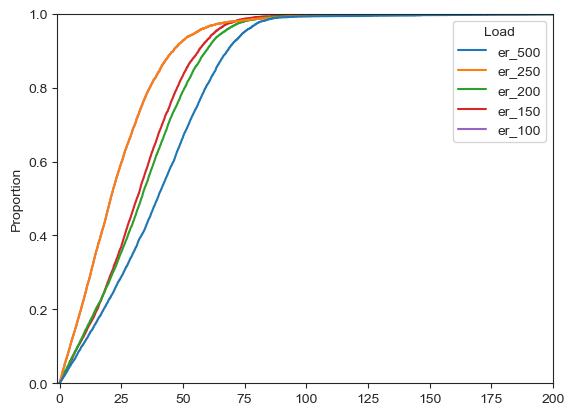

In [56]:
sns.ecdfplot(np.abs(quant_ms2[['er_500','er_250', 'er_200', 'er_150', 'er_100']]), color = myColors).set(xlim = (-1,200))

#### Library only -MS2

In [57]:
quant_ms1 = full.loc[(full.direct == False) & (full['PEP.UsedForProteinGroupQuantity'] == True)].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()
quant_ms2 = full.loc[(full.direct == False) & (full['PEP.UsedForProteinGroupQuantity'] == True)].pivot_table(values="PEP.MS2Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index()

<AxesSubplot:xlabel='er_100', ylabel='Count'>

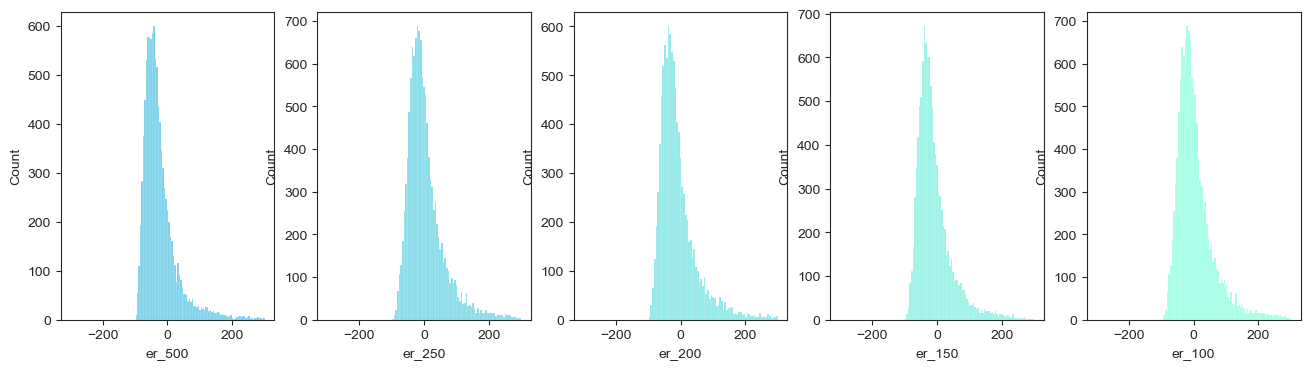

In [58]:
#Everything relative to 50pg
quant_ms2['er_500'] = (500/50 - (quant_ms2['500']/quant_ms2['50']))/(quant_ms2['500']/quant_ms2['50']) * 100
quant_ms2['er_250'] = (100/50 - (quant_ms2['100']/quant_ms2['50']))/(quant_ms2['100']/quant_ms2['50']) * 100
quant_ms2['er_200'] = (200/50 - (quant_ms2['200']/quant_ms2['50']))/(quant_ms2['200']/quant_ms2['50']) * 100
quant_ms2['er_150'] = (150/50 - (quant_ms2['150']/quant_ms2['50']))/(quant_ms2['150']/quant_ms2['50']) * 100
quant_ms2['er_100'] = (100/50 - (quant_ms2['100']/quant_ms2['50']))/(quant_ms2['100']/quant_ms2['50']) * 100



fig, axes = plt.subplots(1,5, figsize = (16,4))
sns.histplot(data = quant_ms2, x = 'er_500', color = myColors[5], ax =axes[0], binrange=(-300,300))
sns.histplot(data = quant_ms2, x = 'er_250', color = myColors[6], ax =axes[1], binrange=(-300,300))
sns.histplot(data = quant_ms2, x = 'er_200', color = myColors[7], ax =axes[2], binrange=(-300,300))
sns.histplot(data = quant_ms2, x = 'er_150', color = myColors[8], ax =axes[3], binrange=(-300,300))
sns.histplot(data = quant_ms2, x = 'er_100', color = myColors[9], ax =axes[4], binrange=(-300,300))

[(-1.0, 200.0)]

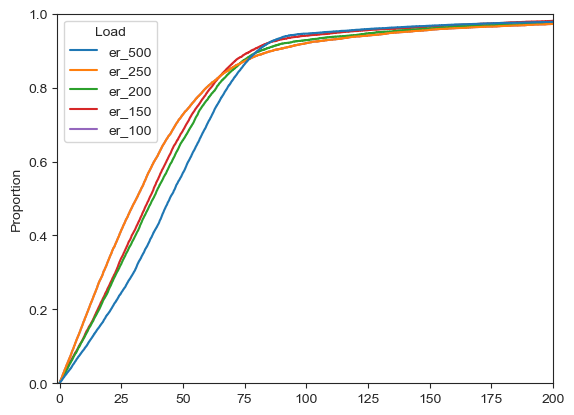

In [59]:
sns.ecdfplot(np.abs(quant_ms2[['er_500','er_250', 'er_200', 'er_150', 'er_100']]), color = myColors).set(xlim = (-1,200))

In [60]:
df.columns

NameError: name 'df' is not defined

In [ ]:
quant.to_csv("data/Exp4/output/standartDIA_quant_diann.txt", sep = "\t", index = False)
quant_wide.to_csv("data/Exp4/output/standartDIA_quant_diann_wide.txt", sep = "\t", index = False)

NameError: name 'quant' is not defined